# Data Preprocessing

Includes imputation and deletion of bad features.

### Import Dependencies

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

### Load Data

In [ ]:
train_base_df = pd.read_csv("project/data/train/features.csv", parse_dates = ['date_recorded' ],  na_values = [0, '0'])
labels = pd.read_csv("project/data/train/labels.csv")

test_df = pd.read_csv("project/data/test/test.csv", parse_dates = ['date_recorded' ],  na_values = [0, '0'])

# Merge features and labels files
train_df = pd.merge(labels, train_base_df, on='id')

print("Numerical columns: \n", train_df.select_dtypes(include=np.number).columns.tolist())

Numerical columns: 
 ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']


In [ ]:
train_df = pd.concat([train_df, test_df])
train_df.head(5)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,NaN,Lake Nyasa,Mnyusi B,Iringa,11,5.0,Ludewa,Mundindi,109.0,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,NaN,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,NaN,Lake Victoria,Nyamara,Mara,20,2.0,Serengeti,Natta,280.0,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,NaN,Pangani,Majengo,Manyara,21,4.0,Simanjiro,Ngorika,250.0,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,NaN,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,NaN,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63.0,Nanyumbu,Nanyumbu,58.0,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,NaN,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,NaN,Lake Victoria,Kyanyamisa,Kagera,18,1.0,Karagwe,Nyakasimbi,NaN,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## 1. Data Imputation

In [ ]:
missing = round((train_df.isna().sum())/len(train_df)*100,1)
missing = missing.sort_values(ascending = False)
missing.head(15)

num_private          98.7
amount_tsh           70.1
scheme_name          47.5
population           36.1
construction_year    35.0
gps_height           34.5
status_group         20.0
installer             7.4
funder                7.4
scheme_management     6.5
public_meeting        5.6
permit                5.1
longitude             3.1
subvillage            0.6
payment_type          0.0
dtype: float64

### Longitude Imputation

0 values are replaced by subvillage, ward, lga, or region's mean logitude values for each column. 

Solution by BrendaLoznik

In [ ]:
train_df['longitude'].isna().sum()

2269

In [ ]:
# train_df['longitude'].replace(0, np.nan, inplace=True)
#create mean longitude on the lowest granularity level (subvillage)
means_longitude_subvillage = train_df.groupby(['region', 'lga', 'ward', 'subvillage'])['longitude'].mean().reset_index()
means_longitude_subvillage = means_longitude_subvillage.rename(columns={"longitude": "longitude_imputed_subvillage"})

#ward level
means_longitude_ward = train_df.groupby(['region', 'lga', 'ward',])['longitude'].mean().reset_index()
means_longitude_ward = means_longitude_ward.rename(columns={"longitude": "longitude_imputed_ward"})

#lga level
means_longitude_lga = train_df.groupby(['region', 'lga'])['longitude'].mean().reset_index()
means_longitude_lga = means_longitude_lga .rename(columns={"longitude": "longitude_imputed_lga"})

#region level
means_longitude_region = train_df.groupby(['region'])['longitude'].mean().reset_index()
means_longitude_region = means_longitude_region.rename(columns={"longitude": "longitude_imputed_region"})
means_longitude_region.head()

,region,longitude_imputed_region
0,Arusha,36.554067
1,Dar es Salaam,39.212935
2,Dodoma,36.041964
3,Iringa,34.895921
4,Kagera,31.233092


In [ ]:
#merge the aggregated dataframes as new columns to the original df
train_df= train_df.merge(means_longitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
train_df= train_df.merge(means_longitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
train_df = train_df.merge(means_longitude_lga, how = 'left', on = ['region', 'lga'])
train_df = train_df.merge(means_longitude_region, how = 'left', on = ['region'])

#select the right longitude level based on the availability of information
train_df['imputed_longitude'] = np.where(train_df['longitude'].isna(), train_df['longitude_imputed_subvillage'], train_df['longitude']) #if longitude is missing, impute it by the mean of the subvillage
train_df['imputed_longitude'] = np.where(train_df['imputed_longitude'].isna(), train_df['longitude_imputed_ward'], train_df['imputed_longitude']) #if subvillage mean is missing, impute it by the ward
train_df['imputed_longitude'] = np.where(train_df['imputed_longitude'].isna(), train_df['longitude_imputed_lga'], train_df['imputed_longitude'])
train_df['imputed_longitude'] = np.where(train_df['imputed_longitude'].isna(), train_df['longitude_imputed_region'], train_df['imputed_longitude'])

#drop redundant columns
train_df= train_df.drop(['longitude_imputed_subvillage','longitude_imputed_ward' , 'longitude_imputed_lga' , 'longitude_imputed_region', 'longitude'], axis=1)

In [ ]:
train_df['imputed_longitude'].isna().sum()

0

### Latitude Imputation

0 values are replaced by subvillage, ward, lga, or region's mean latitude values for each column. 

Solution by Adam

In [ ]:
df = train_df.copy()

In [ ]:
df['latitude'].where(df["latitude"] <= -0.5, np.nan, inplace=True)
df['latitude'].isna().sum()

2269

In [ ]:
#create mean latitude on the lowest granularity level (subvillage)
means_latitude_subvillage = df.groupby(['region', 'lga', 'ward', 'subvillage'])['latitude'].mean().reset_index()
means_latitude_subvillage = means_latitude_subvillage.rename(columns={"latitude": "latitude_imputed_subvillage"})

#ward level
means_latitude_ward = df.groupby(['region', 'lga', 'ward',])['latitude'].mean().reset_index()
means_latitude_ward = means_latitude_ward.rename(columns={"latitude": "latitude_imputed_ward"})

#lga level
means_latitude_lga = df.groupby(['region', 'lga'])['latitude'].mean().reset_index()
means_latitude_lga = means_latitude_lga .rename(columns={"latitude": "latitude_imputed_lga"})

#region level
means_latitude_region = df.groupby(['region'])['latitude'].mean().reset_index()
means_latitude_region = means_latitude_region.rename(columns={"latitude": "latitude_imputed_region"})
means_latitude_region.head()

,region,latitude_imputed_region
0,Arusha,-3.245240
1,Dar es Salaam,-6.908390
2,Dodoma,-5.940758
3,Iringa,-8.908507
4,Kagera,-1.960664


In [ ]:
#merge the aggregated dataframes as new columns to the original df
df = df.merge(means_latitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
df = df.merge(means_latitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
df = df.merge(means_latitude_lga, how = 'left', on = ['region', 'lga'])
df = df.merge(means_latitude_region, how = 'left', on = ['region'])

#select the right latitude level based on the availability of information
df['imputed_latitude'] = np.where(df['latitude'].isna(), df['latitude_imputed_subvillage'], df['latitude']) #if longitude is missing, impute it by the mean of the subvillage
df['imputed_latitude'] = np.where(df['imputed_latitude'].isna(), df['latitude_imputed_ward'], df['imputed_latitude']) #if subvillage mean is missing, impute it by the ward
df['imputed_latitude'] = np.where(df['imputed_latitude'].isna(), df['latitude_imputed_lga'], df['imputed_latitude'])
df['imputed_latitude'] = np.where(df['imputed_latitude'].isna(), df['latitude_imputed_region'], df['imputed_latitude'])

#drop redundant columns
df= df.drop(['latitude_imputed_subvillage','latitude_imputed_ward' , 'latitude_imputed_lga' , 'latitude_imputed_region', 'latitude'], axis=1)

In [ ]:
df['imputed_latitude'].isna().sum()

0

In [ ]:
#function to create density plot
def impute_checker (feature, imputed_dataset, title):
  train_df[feature].plot(kind='kde', c='black')
  imputed_dataset[feature].plot(kind='kde', style = "--", c= '#66c2a5')
  labels = ['Original df', 'Imputed df']
  plt.legend(labels)
  plt.xlabel(feature)
  plt.title(title)
  plt.show()

In [ ]:
if sw_impute_latitude:
    train_df = df

### Permit Imputation
Impute missing values with mode of similar records. `management_group` and `public_meeting` were used by BrendaLoznik.

In [ ]:
#impute by mode
permit_mg_mode= train_df.groupby(['public_meeting', 'management_group'])['permit'].agg(pd.Series.mode).reset_index()
permit_mg_mode  = permit_mg_mode.rename(columns={"permit": "imputed_permit_mg"})
train_df = train_df.merge(permit_mg_mode, how = 'left', on = ['public_meeting', 'management_group'])

train_df['imputed_permit'] = np.where(train_df['permit'].isna(), train_df['imputed_permit_mg'], train_df['permit'])  #if permit is missing, replace it by the mode of public meeting - management group
train_df['imputed_permit']  = np.where(train_df['imputed_permit'] .isna(), train_df['permit'].mode(), train_df['imputed_permit'])  #if eitther public meeting or management group is missing, then use the mode of permit (True)

#drop original permit column
train_df = train_df.drop(['permit', 'imputed_permit_mg'], axis=1)

### Public Meeting Imputation
Simply impute public_meeting with the mode, as 90% of pumps have a TRUE value

Solution by BrendaLoznik extended by Filip

In [ ]:
public_meeting_mode = train_df['public_meeting'].mode()[0]
train_df['public_meeting'] = train_df['public_meeting'].fillna(public_meeting_mode).astype(object)

### Scheme Management Imputation

Solution by BrendaLoznik

In [ ]:
# it seems like a logical choice to impute missing scheme management values by the mode of the management - scheme-management as there is a lot of overlap here
check = train_df.groupby([  'management_group', 'scheme_management' , 'management'])['id'].count().reset_index()
check = check.sort_values('management')
check.head(10)

scheme_mode = train_df.groupby(['management'])['scheme_management'].agg(pd.Series.mode).reset_index()
scheme_mode = scheme_mode.rename(columns={"scheme_management": "imputed_scheme_management"})
scheme_mode 

#merge scheme_mode to original df and use it to replace missing values
train_df = train_df.merge(scheme_mode, how = 'left', on = [ 'management'])
train_df['imputed_scheme__management'] = np.where(train_df['scheme_management'].isna(), train_df['imputed_scheme_management'], train_df['scheme_management'])

#drop redundant columns
train_df= train_df.drop(['scheme_management', 'imputed_scheme_management'],axis=1)



### Installer

Solution 1 by BrendaLoznik

Solution 2 by Adam

In [ ]:
# Solution 1

if not sw_use_new_installer_method:

    #I noticed a lot of variation in captialization, so I will first convert al entries to lowercase
    train_df['installer'] = train_df['installer'].str.lower()

    #plot top 10 installers
    installer = train_df.groupby('installer')['id'].count().reset_index()
    installer = installer.sort_values('id', ascending = False)
    installer.head(10)


    #there are a few categories in the top 60 most common categories whose naims look a lot alike and are probably typo's. We will merge them together
    train_df['installer'] = np.where( train_df['installer']=='gove', 'gover', train_df['installer'] )
    train_df['installer'] = np.where( train_df['installer']=='community', 'commu', train_df['installer'] )
    train_df['installer'] = np.where( train_df['installer']=='danid', 'danida', train_df['installer'] )

    installer = train_df.groupby('installer')['id'].count().reset_index()
    installer = installer.sort_values('id', ascending = False)
    installer.head(10)

    #I want to keep the most frequent installers and combine the rarer classes together. I have played around with the optimum number of installers to keep, and I decided on the top 150.

    #create list of top 150 installers
    top_installers = installer.nlargest(150, 'id')['installer'].unique()

    #replace funders that are not in top 10 with 'other'
    train_df['installer'] = np.where(train_df['installer'].isin(top_installers), train_df['installer'], 'other')


In [ ]:
# Solution 2

if sw_use_new_installer_method:
    
    # Combine installers with less than 20 instances into "other"
    train_df['installer'] = train_df['installer'].str.lower()

    # Compute the value counts of the column
    value_counts = train_df['installer'].value_counts()

    # Identify values with fewer than X instances, including NaN values
    values_to_replace = value_counts[value_counts < 20].index.tolist()
    values_to_replace.append(np.nan)

    # Replace values with "other"
    train_df['installer'] = train_df['installer'].replace(values_to_replace, "other")

    # Perform target encoding
    # Calculate the percentage of 'functional' label for each unique value in the 'combined' column
    target_percentage = train_df.groupby('installer')['status_group'].apply(lambda x: (x == 'functional').mean())

    # Map the target percentage encoding values back to the 'combined' column
    train_df['installer'] = train_df['installer'].map(target_percentage)


### Funder

Solution 1 by BrendaLoznik

Solution 2 by Adam

In [ ]:
# Solution 1

if not sw_use_new_funder_method:
    #set all entries to lowercase
    train_df['funder'] = train_df['funder'].str.lower()

    funder = train_df.groupby('funder')['id'].count().reset_index()
    funder = funder.sort_values('id', ascending = False)
    funder.head(10)

    #create list of top 150 funders
    top_funders = funder.nlargest(150, 'id')['funder'].unique()

    #replace funders that are not in top 150 with 'other'
    train_df['funder'] = np.where(train_df['funder'].isin(top_funders), train_df['funder'], 'other')

In [ ]:
# Solution 2

if sw_use_new_funder_method:
    
    # Combine funders with less than 20 instances into "other"
    train_df['funder'] = train_df['funder'].str.lower()

    # Compute the value counts of the column
    value_counts = train_df['funder'].value_counts()

    # Identify values with fewer than X instances, including NaN values
    values_to_replace = value_counts[value_counts < 20].index.tolist()
    values_to_replace.append(np.nan)

    # Replace values with "other"
    train_df['funder'] = train_df['funder'].replace(values_to_replace, "other")
    print(train_df["funder"].unique().size)
    print(train_df["funder"].value_counts())

    # Perform target encoding
    # Calculate the percentage of 'functional' label for each unique value in the 'combined' column
    target_percentage = train_df.groupby('funder')['status_group'].apply(lambda x: (x == 'functional').mean())

    # Map the target percentage encoding values back to the 'combined' column
    train_df['funder'] = train_df['funder'].map(target_percentage)

315
government of tanzania    11299
other                     10706
danida                     3907
hesawa                     2782
rwssp                      1703
                          ...  
mkuyu                        20
tasaf/dmdd                   20
one un                       20
ubalozi wa marekani          20
rdc                          20
Name: funder, Length: 315, dtype: int64


### Construction Year Imputation

Since `extraction_type_group` is associated with `construction_year`, that will help to impute the values.

Solution by BrendaLoznik

In [ ]:
#because of the wide spread of construction years, I don't want to impude by the overall mean
train_df['construction_year'].min(),  train_df['construction_year'].max() , train_df['construction_year'].mean()

#We can see that the mean construction year by extraction type group gives much more detailed information
mean_construction = train_df.groupby('extraction_type_group')['construction_year'].mean().reset_index()

#create train_df with the mean extraction year by extraction type group
mean_construction = train_df.groupby('extraction_type_group')['construction_year'].mean().reset_index()
mean_construction  = mean_construction .rename(columns={"construction_year": "imputed_construction_year"})

#merge this train_df to the main train_df and replace missing values
train_df = train_df.merge(mean_construction, how =  'left', on =  'extraction_type_group')
train_df['construction_year_imputed'] = np.where(train_df['construction_year'].isna(), train_df['imputed_construction_year'], train_df['construction_year'] )

#drop redundant columns
train_df=train_df.drop(['imputed_construction_year', 'construction_year'], axis=1)

### GPS Height Imputation

**1: Solution by BrendaLoznik**

Replace values randomly within 1std of the mean, following a normal distribution.
This probably needs verifying/improving but it'll do for now.

**2: Filip's Solution**

Use SRTM (Shuttle Radar Topography Mission) data for Tanzania downloaded from [AfricaGeoPortal](https://rcmrd.africageoportal.com/datasets/rcmrd::tanzania-srtm-dem-30-meters/about). Although this is not used for the competition submissions (it is not allowed to use external data), this is a solution we would use if we were trying to solve the problem. 

In [ ]:
# Solution 1

if not sw_gps_height_model_imput:
    #create mean on the lowest granularity level (subvillage)
    means_altitude_subvillage = train_df.groupby(['region', 'lga', 'ward', 'subvillage'])['gps_height'].mean().reset_index()#
    means_altitude_subvillage = means_altitude_subvillage.rename(columns={"gps_height": "gps_height_imputed_subvillage"})

    #ward level
    means_altitude_ward = train_df.groupby(['region', 'lga', 'ward',])['gps_height'].mean().reset_index()
    means_altitude_ward = means_altitude_ward.rename(columns={"gps_height": "gps_height_imputed_ward"})

    #lga level
    means_altitude_lga = train_df.groupby(['region', 'lga'])['gps_height'].mean().reset_index()
    means_altitude_lga = means_altitude_lga .rename(columns={"gps_height": "gps_height_imputed_lga"})

    #region level
    means_altitude_region = train_df.groupby(['region'])['gps_height'].mean().reset_index()
    means_altitude_region = means_altitude_region.rename(columns={"gps_height": "gps_height_imputed_region"})

    #region basin
    means_altitude_basin = train_df.groupby(['basin'])['gps_height'].mean().reset_index()
    means_altitude_basin = means_altitude_basin.rename(columns={"gps_height": "gps_height_imputed_basin"})

    #merge the aggregated dataframes as new columns to the original train_df
    train_df= train_df.merge(means_altitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
    train_df = train_df.merge(means_altitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
    train_df = train_df.merge(means_altitude_lga, how = 'left', on = ['region', 'lga'])
    train_df = train_df.merge(means_altitude_region, how = 'left', on = ['region'])
    train_df = train_df.merge(means_altitude_basin, how = 'left', on = ['basin'])

    #create final imputed longitude column
    train_df['imputed_gps_height'] = np.where(train_df['gps_height'].isna(), train_df['gps_height_imputed_subvillage'], train_df['gps_height']) #if longitude is missing, impute it by the mean of the subvillage
    train_df['imputed_gps_height'] = np.where(train_df['imputed_gps_height'].isna(), train_df['gps_height_imputed_ward'], train_df['imputed_gps_height']) #if subvillage mean is missing, impute it by the ward
    train_df['imputed_gps_height'] = np.where(train_df['imputed_gps_height'].isna(), train_df['gps_height_imputed_lga'], train_df['imputed_gps_height'])
    train_df['imputed_gps_height'] = np.where(train_df['imputed_gps_height'].isna(), train_df['gps_height_imputed_region'], train_df['imputed_gps_height'])
    train_df['imputed_gps_height'] = np.where(train_df['imputed_gps_height'].isna(), train_df['gps_height_imputed_basin'], train_df['imputed_gps_height'])

    #drop redundant columns
    train_df= train_df.drop(['gps_height_imputed_subvillage','gps_height_imputed_ward' , 'gps_height_imputed_lga' , 'gps_height_imputed_region', 'gps_height', 'gps_height_imputed_basin'], axis=1)


In [ ]:
# Solution 2

import pandas as pd
import rasterio

if sw_gps_height_model_imput:

    df = train_df.copy()

    if sw_impute_latitude:
        latitude = 'imputed_latitude'
    else:
        latitude = 'latitude'

    # Specify the path to the SRTM file for Tanzania
    srtm_file = "Tanzania_SRTM30meters.tif"

    # Create a mask for rows where 'gps_height' is null
    null_height_mask = df['gps_height'].isna()

    # Retrieve the elevation values for rows with null 'gps_height'
    elevations = []

    with rasterio.open(srtm_file) as dataset:
        elevation_data = dataset.read(1)

        for idx, row in df[null_height_mask].iterrows():
            # Transform latitude and longitude to pixel coordinates
            row_idx, col_idx = dataset.index(row['imputed_longitude'], row[latitude])
            # Read the elevation value at the pixel coordinates
            elevation = elevation_data[row_idx, col_idx]
            elevations.append(elevation)

    # Assign the retrieved elevations to the 'gps_height' column
    df.loc[null_height_mask, 'gps_height'] = elevations


    train_df['imputed_gps_height'] = df['gps_height']
    train_df= train_df.drop('gps_height', axis=1)

### Population
Brenda's solution considers region-wide population average when not available, which is a poor indicator of population. Some readings also have very large population values, which skew the average. We use a binning approach to better represent population, with a "missing" bin where subvillage or ward population is unknown, as this itself is a decent predictor.

Solution by BrendaLoznik extended by Adam with considering "1" values as missing

In [ ]:
# Convert 1 values to NaN by Filip
train_df["population"] = train_df["population"].replace(1, np.nan)

In [ ]:
#create mean on the lowest granularity level (subvillage)
means_population_subvillage = train_df.groupby(['region', 'lga', 'ward', 'subvillage'])['population'].mean().reset_index()#
means_population_subvillage = means_population_subvillage.rename(columns={"population": "population_imputed_subvillage"})

#ward level
means_population_ward = train_df.groupby(['region', 'lga', 'ward',])['population'].mean().reset_index()
means_population_ward = means_population_ward.rename(columns={"population": "population_imputed_ward"})

#lga level
means_population_lga = train_df.groupby(['region', 'lga'])['population'].mean().reset_index()
means_population_lga = means_population_lga .rename(columns={"population": "population_imputed_lga"})

#region level
means_population_region = train_df.groupby(['region'])['population'].mean().reset_index()
means_population_region = means_population_region.rename(columns={"population": "population_imputed_region"})

#region basin
means_population_basin = train_df.groupby(['basin'])['population'].mean().reset_index()
means_population_basin = means_population_basin.rename(columns={"population": "population_imputed_basin"})

#merge the aggregated dataframes as new columns to the original df
train_df= train_df.merge(means_population_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
train_df = train_df.merge(means_population_ward, how = 'left', on = ['region', 'lga', 'ward'])
train_df = train_df.merge(means_population_lga, how = 'left', on = ['region', 'lga'])
train_df = train_df.merge(means_population_region, how = 'left', on = ['region'])
train_df = train_df.merge(means_population_basin, how = 'left', on = ['basin'])

#create final imputed longitude column
train_df['imputed_population'] = np.where(train_df['population'].isna(), train_df['population_imputed_subvillage'], train_df['population']) #if longitude is missing, impute it by the mean of the subvillage
train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_ward'], train_df['imputed_population']) #if subvillage mean is missing, impute it by the ward
train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_lga'], train_df['imputed_population'])
train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_region'], train_df['imputed_population'])
train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_basin'], train_df['imputed_population'])

#drop redundant columns
train_df= train_df.drop(['population_imputed_subvillage','population_imputed_ward' , 'population_imputed_lga' , 'population_imputed_region', 'population', 'population_imputed_basin'], axis=1)

### Correct data types

Solution by BrendaLoznik

In [ ]:
#replace string to integer
train_df['public_meeting'] = train_df['public_meeting'].replace({True: 1, False: 0})
train_df['imputed_permit'] = train_df['imputed_permit'].replace({True: 1, False: 0})


#change to integer
train_df[['imputed_gps_height', 'construction_year_imputed', 'imputed_population']] = train_df[['imputed_gps_height', 'construction_year_imputed', 'imputed_population']].astype('int')

#change type to categorical
train_df[['region_code', 'district_code', 'num_private']] = train_df[['region_code', 'district_code', 'num_private']].astype('str')
train_df[[ 'num_private']] = train_df[[ 'num_private']].astype('str')

#remove decimal
train_df['district_code'] = train_df['district_code'].str.split(".").str[0]


In [ ]:
#save cleaned df
train_df= train_df.rename(columns={"imputed_permit": "permit", "imputed_scheme__management": "scheme_management",
                    "imputed_gps_height": "gps_height", 'construction_year_imputed': 'construction_year', 
                   'imputed_population': 'population', 'imputed_longitude': 'longitude'}, errors="raise")

if sw_impute_latitude:
    train_df = train_df.rename(columns={'imputed_latitude': 'latitude'}, errors="raise")

train_df.to_csv("cleaned_df.csv")

In [ ]:
train_df.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder',
       'installer', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'public_meeting',
       'recorded_by', 'scheme_name', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'longitude',
       'latitude', 'permit', 'scheme_management', 'construction_year',
       'gps_height', 'population'],
      dtype='object')

## 2. Feature Engineering

### recorded_age Feature
Create a feature recorded_age, which states the age (in years) of the pump at time of recording. Uses date_recorded and construction_year.

Solution by BrendaLoznik

In [ ]:
#create age feature
train_df['recorded_year'] = pd.DatetimeIndex(train_df ['date_recorded']).year
train_df[ 'age'] = train_df['recorded_year'] - train_df['construction_year']
train_df = train_df.drop('recorded_year',axis=1)

### Recorded Season
The month in which the water pump's functionality is recorded may be important due to wet/dry seasons in Tanzania. Due to the poor distribution of recorded months, we group months into different season bins.

Solution by BrendaLoznik

In [ ]:
train_df['month'] = pd.DatetimeIndex(train_df['date_recorded']).month

# season encoder
season_mapper = {1: 'short dry',2:'short dry', 3: 'long rain', 4: 'long rain', 5: 'long rain',6: 'long dry', 
                 7: 'long dry', 8: 'long dry', 9: 'long dry', 10: 'long dry', 11:'short rain', 12:'short rain'}
#.p feature values to scale
train_df['season'] = train_df['month'].replace(season_mapper)
# train_df = train_df.drop('month', axis=1)

### amount_tsh missing
Use a binary feature for whether amount_tsh is missing - this is a decent predictor of water pump status

Solution by BrendaLoznik

In [ ]:
train_df['amount_tsh_missing'] = np.where( train_df['amount_tsh'].isna(), 1, 0)

### Region District

Solution by BrendaLoznik

In [ ]:
train_df['region_district'] = train_df['region']+ "-" + train_df['district_code']

### Reduce Cardinality of Longitude/Latitude

Solution by BrendaLoznik extended by Filip

In [ ]:
#two decimal places is 1.1 km accurate. This will provide enough information on the location. Using the full coordinate doesn't provide a lot of general information, but does result in high cardinality
train_df['longitude_rounded'] = round(train_df['longitude'], 2)
train_df['latitude_rounded'] = round(train_df['latitude'],2)

# train_df = train_df.drop('longitude', axis=1)
# train_df = train_df.drop('latitude', axis=1)

### Reduce Cardinality of GPS Height

We round the height to tens. 10 meters is enough accuracy.

Solution by Filip

In [ ]:
if sw_gps_height_reduce_card:
    train_df['gps_height_rounded'] = train_df['gps_height'].round(-1).astype(int)

# train_df = train_df.drop('gps_height', axis=1)

### Extraction

Solution by BrendaLoznik

In [ ]:
#i want to keep extraction type class and I will group the extraction type group en type together

#swn 80 and swn 81 become swn
#cemo + climax become other motorpump
# other -mkulima, other -play and walimi become other handpump

train_df['extraction_type_engineered'] = train_df['extraction_type']

swn = ['other - swn 81', 'swn80']
train_df['extraction_type_engineered'] =np.where(train_df['extraction_type_engineered'].isin(swn), 'swn',  train_df['extraction_type_engineered'])

other_handpump = ['other - mkulima/shinyanga', 'other - play pump', 'other - walimi']
train_df['extraction_type_engineered']=np.where(train_df['extraction_type_engineered'].isin(other_handpump), 'other handpump',  train_df['extraction_type_engineered'])

other_motorpump = ['cemo', 'climax']
train_df['extraction_type_engineered'] =np.where(train_df['extraction_type_engineered'].isin(other_motorpump), 'other motorpump',  train_df['extraction_type_engineered'])


### Extraction Type Class

There are very few datapoints with `wind-powered` and `rope pump`. Since `motorpump` has mostly similar label distribution to `wind-powered` and `rope pump` has mostly similar label distribution to `handpump`, we merge the former into the latter.

Solution by Filip

In [ ]:
df = train_df.copy()
distribution_checker(df, 'extraction_type_class')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type_class,,,,,
gravity,26780,45.1,59.9,30.0,10.1
handpump,16455,27.7,63.1,30.9,6.0
motorpump,2987,5.0,38.0,57.4,4.6
other,6430,10.8,16.0,80.8,3.2
rope pump,451,0.8,65.0,31.3,3.8
submersible,6179,10.4,53.9,42.0,4.1
wind-powered,117,0.2,42.7,51.3,6.0


In [ ]:
# Merge 'wind-powered' class into 'motorpump'
df['extraction_type_class_engineered'] = df['extraction_type_class'].replace('wind-powered', 'motorpump')

# Merge 'rope pump' into 'handpump'
df['extraction_type_class_engineered'] = df['extraction_type_class_engineered'].replace('rope pump', 'handpump')

In [ ]:
distribution_checker(df, 'extraction_type_class_engineered')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type_class_engineered,,,,,
gravity,26780,45.1,59.9,30.0,10.1
handpump,16906,28.5,63.1,30.9,6.0
motorpump,3104,5.2,38.2,57.2,4.7
other,6430,10.8,16.0,80.8,3.2
submersible,6179,10.4,53.9,42.0,4.1


In [ ]:
if sw_extraction_type_class_eng:
    train_df = df

### Autonomy

Solution by BrendaLoznik

In [ ]:
#autonomous = government, VWC, town council ..... also water authority?, parastatal (=state company)? SWC?
#autonomous = WUA, WUG, board, trust, school
#private = private, company

non = ['VWC', 'Water authority', 'Parastatal', 'SWC']
autonomous = ['WUG', 'WUA', 'Water Board', 'Trust']
private = ['Company', 'Private operator']
other = ['None', 'Other']

train_df['scheme_management_engineered'] = train_df['scheme_management']
train_df.loc[train_df['scheme_management_engineered'].isin(non),'scheme_management_engineered']='non-autonomous'
train_df.loc[train_df['scheme_management_engineered'].isin(autonomous ),'scheme_management_engineered']='autonomous'
train_df.loc[train_df['scheme_management_engineered'].isin(private),'scheme_management_engineered']='private'
train_df.loc[train_df['scheme_management_engineered'].isin(other ),'scheme_management_engineered']='other'

### Combine rare features in `source`

Solution by BrendaLoznik

In [ ]:
#keep source, but the rare classes will be put together
other = ['other',  'unknown']
train_df['source_engineered'] = train_df['source']
train_df['source_engineered'] = np.where(train_df['source_engineered']=='unknown', 'other', train_df['source_engineered'])

# train_df = train_df.drop('source', axis=1)

### Population

Adding bins to reduce cardinality

Solution by Filip

In [ ]:
df = train_df.copy()

# bin the population column and assign labels
bins = [0, 100, 200, 500, 1000, 100000]
df['population_engineered'] = pd.cut(df['population'], bins=bins, labels=['very small', 'small', 'medium', 'large', 'very large']).astype('object')

# df = df.drop('population', axis=1)

distribution_checker(df, 'population_engineered')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
population_engineered,,,,,
large,11866,20.0,50.2,43.0,6.8
medium,24185,40.7,49.5,41.5,9.0
small,11444,19.3,60.7,33.2,6.2
very large,1928,3.2,54.3,40.7,5.1
very small,9976,16.8,63.5,31.2,5.3


In [ ]:
if sw_population_bins:
    train_df = df

### Regional target encoding

Features `region`, `lga` are turned into a single variable and target encoded. Adding `ward`, `subvillage` to that would make cardinality increase cardinality too much, so they are dropped. The obtained feature has sequential property with higher values being associated with functional pumps.

Solution by Filip

In [ ]:
df = train_df.copy()

In [ ]:
# Combine the columns into a new column using the 'apply' method
df['combined'] = df[['region', 'lga']].apply(lambda x: '-'.join(x.dropna().astype(str)), axis=1)

In [ ]:
distribution_checker(df, 'combined')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
combined,,,,,
Arusha-Arusha Rural,1252,2.1,69.9,26.3,3.8
Arusha-Arusha Urban,63,0.1,66.7,22.2,11.1
Arusha-Karatu,326,0.5,96.9,2.8,0.3
Arusha-Longido,310,0.5,64.5,26.1,9.4
Arusha-Meru,1009,1.7,65.1,31.7,3.2
...,...,...,...,...,...
Tanga-Lushoto,694,1.2,62.4,29.1,8.5
Tanga-Mkinga,288,0.5,77.8,22.2,0.0
Tanga-Muheza,334,0.6,65.6,34.4,0.0


In [ ]:
# Calculate the percentage of 'functional' label for each unique value in the 'combined' column
target_percentage = df.groupby('combined')['status_group'].apply(lambda x: (x == 'functional').mean())

# Map the target percentage encoding values back to the 'combined' column
df['region_encoded'] = df['combined'].map(target_percentage)

# Delete unnecessary columns
df = df.drop('combined', axis=1)

In [ ]:
distribution_checker(df, 'region_encoded').sort_values('region_encoded').head(20)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
region_encoded,,,,,
0.000000,1,0.0,0.0,100.0,0.0
0.069333,300,0.5,8.7,86.3,5.0
0.149425,291,0.5,17.9,75.3,6.9
0.157895,71,0.1,21.1,67.6,11.3
0.158706,528,0.9,19.5,67.6,12.9
0.173333,305,0.5,21.3,77.7,1.0
0.177866,193,0.3,23.3,62.2,14.5
0.180812,231,0.4,21.2,65.8,13.0
0.188437,358,0.6,24.6,65.4,10.1


In [ ]:
if sw_region_target_encoding:
    train_df = df

### Waterpoint Type
Some categories in Waterpoint Type have very few instances, primarily `dam` and `cattle trough`, so we merge these into other categories based on their similarity to other features, including `source_type` and `source_class`. The mode from this is selected.

Solution by Adam

In [ ]:
train_df['waterpoint_type'].info()

<class 'pandas.core.series.Series'>
Int64Index: 74249 entries, 0 to 74248
Series name: waterpoint_type
Non-Null Count  Dtype 
--------------  ----- 
74249 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


In [ ]:
if sw_waterpoint_type_adjust:
    train_df["waterpoint_type_engineered"] = train_df["waterpoint_type"]
    train_df["waterpoint_type_engineered"] = train_df["waterpoint_type_engineered"].replace(["dam"], [pd.NA])
    train_df["waterpoint_type_engineered"] = train_df["waterpoint_type_engineered"].replace(["cattle trough"], [pd.NA])

    modes = train_df.groupby(["source", "source_type", "source_class"])["waterpoint_type_engineered"].apply(lambda x: x.mode()[0]).reset_index()

    train_df["waterpoint_type_engineered"] = train_df["waterpoint_type_engineered"].fillna(df.merge(modes, on=['source', 'source_type', "source_class"], how='left')['waterpoint_type_engineered_y'])

### Pump Density Feature

Create `pump_density` feature based on the distance to 6 closest pumps (using `longitude` and `latitude`). `pump_density_engineered` is a binned version of that feature into 5 well-distributed density classes.

by Filip

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

if sw_pump_density:

    # Assuming you have a DataFrame called 'df' with 'longitude' and 'latitude' columns

    # Extract the 'longitude' and 'latitude' columns
    X = train_df[['longitude', 'latitude']].values

    # Specify the number of nearest neighbors, 'k'
    k = 6

    # Create a NearestNeighbors object and fit the data
    nn = NearestNeighbors(n_neighbors=k+1)  # k+1 to exclude the point itself
    nn.fit(X)

    # Find the distances and indices of the k nearest neighbors for each point
    distances, indices = nn.kneighbors(X)

    # Calculate the average distance to the k nearest neighbors for each point
    average_distances = np.mean(distances[:, 1:], axis=1)  # Exclude the distance to itself

    # Create a new column in the DataFrame with the average distances
    train_df['pump_density'] = abs(average_distances)
    
    # bin the population column and assign labels
    bins = [-0.001, 0.0025, 0.005, 0.0075, 0.01, 0.4]
    train_df['pump_density_engineered'] = pd.cut(train_df['pump_density'], bins=bins, labels=['very small', 'small', 'medium', 'large', 'very large']).astype('object')

    distribution_checker(train_df, 'pump_density_engineered')

## 3. Feature Preselection

Before using feature selection methods, we remove all the completely useless columns (established in EDA) while keeping both versions (pre-engineered and engineered) of all the engineered columns to perform feature selection on them.

In [ ]:
full_df = train_df.copy()

In [ ]:
if sw_brendas_selection:
    # #during EDA I already decided what features to keep and which ones to drop
    train_df = train_df.drop(['amount_tsh', 'date_recorded', 'wpt_name', 'num_private', 'subvillage', 'region',  'district_code', 'lga', 'ward', 'recorded_by', 'scheme_name', 'extraction_type_group', 'management', 'management_group', 'payment', 'quality_group', 'quantity_group', 'source_class', 'source_type', 'waterpoint_type_group', 'construction_year'], axis=1)
else:
    train_df = train_df.drop(['amount_tsh', 'date_recorded', 'wpt_name', 'num_private', 'subvillage',  'district_code', 'recorded_by', 'scheme_name', 'payment', 'quantity_group', 'construction_year', 'ward'], axis=1)

## 4. Oversampling

by Filip

In [ ]:
from imblearn.over_sampling import SMOTENC

df = train_df[train_df['status_group'].notnull()].copy()

# Separate the features and the target variable
X = df.drop('status_group', axis=1)
y = df['status_group']

# Identify the index of the 'functional_needs_repair' class
repair_index = y[y == 'functional needs repair'].index

In [ ]:
# Change the type of numerical values that should be treated as categories

train_df['public_meeting'] = train_df['public_meeting'].astype(object)
train_df['permit'] = train_df['permit'].astype(object)
train_df['month'] = train_df['month'].astype(object)
train_df['amount_tsh_missing'] = train_df['amount_tsh_missing'].astype(object)

In [ ]:
# categorical_cols = [col for col in X.columns if len(X[col].unique()) < 200]
categorical_cols = [cname for cname in X .columns if
                   X [cname].dtype == "object"]

# Convert numerical columns to object type
for col in categorical_cols:
        X[col] = X[col].astype(object)

# Create a categorical mask
cat_mask = [True if col in categorical_cols else False for col in X.columns]

In [ ]:
missing = round((train_df.isna().sum())/len(train_df)*100,1)
missing = missing.sort_values(ascending = False)
missing.head(15)

status_group                  20.0
id                             0.0
longitude_rounded              0.0
permit                         0.0
scheme_management              0.0
gps_height                     0.0
population                     0.0
age                            0.0
month                          0.0
season                         0.0
amount_tsh_missing             0.0
region_district                0.0
latitude_rounded               0.0
gps_height_rounded             0.0
extraction_type_engineered     0.0
dtype: float64

In [ ]:
# Apply SMOTE-NC to oversample the 'functional_needs_repair' class
smotenc = SMOTENC(categorical_features=cat_mask, k_neighbors=5, random_state=42, sampling_strategy={'functional needs repair': 7000})
X_resampled, y_resampled = smotenc.fit_resample(X, y)

In [ ]:
# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['status_group'] = y_resampled

df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62082 entries, 0 to 62081
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                62082 non-null  int64  
 1   funder                            62082 non-null  float64
 2   installer                         62082 non-null  float64
 3   basin                             62082 non-null  object 
 4   region                            62082 non-null  object 
 5   region_code                       62082 non-null  object 
 6   lga                               62082 non-null  object 
 7   public_meeting                    62082 non-null  int64  
 8   extraction_type                   62082 non-null  object 
 9   extraction_type_group             62082 non-null  object 
 10  extraction_type_class             62082 non-null  object 
 11  management                        62082 non-null  object 
 12  mana

In [ ]:
missing = round((train_df.isna().sum())/len(train_df)*100,1)
missing = missing.sort_values(ascending = False)

for col in train_df.columns:
    print(col, len(train_df[col].unique()), missing[col], train_df[col].dtype)

id 74249 0.0 int64
status_group 4 20.0 object
funder 272 0.0 float64
installer 243 0.0 float64
basin 9 0.0 object
region 21 0.0 object
region_code 27 0.0 object
lga 125 0.0 object
public_meeting 2 0.0 object
extraction_type 18 0.0 object
extraction_type_group 13 0.0 object
extraction_type_class 7 0.0 object
management 12 0.0 object
management_group 5 0.0 object
payment_type 7 0.0 object
water_quality 8 0.0 object
quality_group 6 0.0 object
quantity 5 0.0 object
source 10 0.0 object
source_type 7 0.0 object
source_class 3 0.0 object
waterpoint_type 7 0.0 object
waterpoint_type_group 6 0.0 object
longitude 71879 0.0 float64
latitude 71878 0.0 float64
permit 2 0.0 object
scheme_management 12 0.0 object
gps_height 2456 0.0 int64
population 1216 0.0 int64
age 60 0.0 int64
month 12 0.0 object
season 4 0.0 object
amount_tsh_missing 2 0.0 object
region_district 132 0.0 object
longitude_rounded 1074 0.0 float64
latitude_rounded 1057 0.0 float64
gps_height_rounded 270 0.0 int64
extraction_type_e

In [ ]:
if sw_oversampling:
    train_df = pd.concat([df_resampled, train_df[train_df['status_group'].isna()]], ignore_index=True)

In [ ]:
missing = round((train_df.isna().sum())/len(train_df)*100,1)
missing = missing.sort_values(ascending = False)

for col in train_df.columns:
    print(col, len(train_df[col].unique()), missing[col], train_df[col].dtype)

id 74249 0.0 int64
status_group 4 20.0 object
funder 272 0.0 float64
installer 243 0.0 float64
basin 9 0.0 object
region 21 0.0 object
region_code 27 0.0 object
lga 125 0.0 object
public_meeting 2 0.0 object
extraction_type 18 0.0 object
extraction_type_group 13 0.0 object
extraction_type_class 7 0.0 object
management 12 0.0 object
management_group 5 0.0 object
payment_type 7 0.0 object
water_quality 8 0.0 object
quality_group 6 0.0 object
quantity 5 0.0 object
source 10 0.0 object
source_type 7 0.0 object
source_class 3 0.0 object
waterpoint_type 7 0.0 object
waterpoint_type_group 6 0.0 object
longitude 71879 0.0 float64
latitude 71878 0.0 float64
permit 2 0.0 object
scheme_management 12 0.0 object
gps_height 2456 0.0 int64
population 1216 0.0 int64
age 60 0.0 int64
month 12 0.0 object
season 4 0.0 object
amount_tsh_missing 2 0.0 object
region_district 132 0.0 object
longitude_rounded 1074 0.0 float64
latitude_rounded 1057 0.0 float64
gps_height_rounded 270 0.0 int64
extraction_type_e

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74249 entries, 0 to 74248
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                74249 non-null  int64  
 1   status_group                      59399 non-null  object 
 2   funder                            74249 non-null  float64
 3   installer                         74249 non-null  float64
 4   basin                             74249 non-null  object 
 5   region                            74249 non-null  object 
 6   region_code                       74249 non-null  object 
 7   lga                               74249 non-null  object 
 8   public_meeting                    74249 non-null  object 
 9   extraction_type                   74249 non-null  object 
 10  extraction_type_group             74249 non-null  object 
 11  extraction_type_class             74249 non-null  object 
 12  mana

## 5. Encoding

by BrendaLoznik

In [ ]:
# #define train and test 
# train_set = train_df[train_df ["id"].isin(train_base_df["id"])]
# test_set =  train_df[train_df  ["id"].isin(test_df["id"])]

train_set = train_df[train_df['status_group'].notna()]
test_set =  train_df[train_df['status_group'].isna()]

In [ ]:
X = train_set.drop(['id', 'status_group'], axis=1)
y = train_set['status_group']

In [ ]:
X.columns

Index(['funder', 'installer', 'basin', 'region', 'region_code', 'lga',
       'public_meeting', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'longitude', 'latitude', 'permit',
       'scheme_management', 'gps_height', 'population', 'age', 'month',
       'season', 'amount_tsh_missing', 'region_district', 'longitude_rounded',
       'latitude_rounded', 'gps_height_rounded', 'extraction_type_engineered',
       'extraction_type_class_engineered', 'scheme_management_engineered',
       'source_engineered', 'population_engineered', 'region_encoded',
       'waterpoint_type_engineered', 'pump_density',
       'pump_density_engineered'],
      dtype='object')

In [ ]:
categorical_cols = [cname for cname in X .columns if
                   X [cname].dtype == "object"]

In [ ]:
# Encode Categorical Columns 
for col in categorical_cols:
  le = LabelEncoder()
  train_set[col] = le.fit_transform(train_set[col])
  test_set[col] = le.transform(test_set[col])


/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_23830/3744793663.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[col] = le.fit_transform(train_set[col])
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_23830/3744793663.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[col] = le.transform(test_set[col])
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_23830/3744793663.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [ ]:
#merge the encoded train and test sets together
train_df = train_set.append(test_set)

/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_23830/3238694098.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_set.append(test_set)


## 6. Feature Selection

In [ ]:
#basic libraries
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from fcbf import fcbf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
train_df.to_csv("preselection_df.csv")
train_df.columns

Index(['id', 'status_group', 'funder', 'installer', 'basin', 'region',
       'region_code', 'lga', 'public_meeting', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'longitude', 'latitude', 'permit',
       'scheme_management', 'gps_height', 'population', 'age', 'month',
       'season', 'amount_tsh_missing', 'region_district', 'longitude_rounded',
       'latitude_rounded', 'gps_height_rounded', 'extraction_type_engineered',
       'extraction_type_class_engineered', 'scheme_management_engineered',
       'source_engineered', 'population_engineered', 'region_encoded',
       'waterpoint_type_engineered', 'pump_density',
       'pump_density_engineered'],
      dtype='object')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74249 entries, 0 to 74248
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                74249 non-null  int64  
 1   status_group                      59399 non-null  object 
 2   funder                            74249 non-null  float64
 3   installer                         74249 non-null  float64
 4   basin                             74249 non-null  int64  
 5   region                            74249 non-null  int64  
 6   region_code                       74249 non-null  int64  
 7   lga                               74249 non-null  int64  
 8   public_meeting                    74249 non-null  int64  
 9   extraction_type                   74249 non-null  int64  
 10  extraction_type_group             74249 non-null  int64  
 11  extraction_type_class             74249 non-null  int64  
 12  mana

In [ ]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

In [ ]:
#define train and test 
train_set = train_df[train_df['status_group'].notna()].copy()
test_set = train_df[train_df['status_group'].isna()].copy()

#fully encoded and imputed dataframe
train_set.head()

,id,status_group,funder,installer,basin,region,region_code,lga,public_meeting,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,longitude,latitude,permit,scheme_management,gps_height,population,age,month,season,amount_tsh_missing,region_district,longitude_rounded,latitude_rounded,gps_height_rounded,extraction_type_engineered,extraction_type_class_engineered,scheme_management_engineered,source_engineered,population_engineered,region_encoded,waterpoint_type_engineered,pump_density,pump_density_engineered
0,69572,functional,0.672619,0.478992,1,3,2,51,1,3,1,0,7,4,0,6,2,1,8,6,0,1,1,34.938093,-9.856322,0,7,1390,109,12,2,1,0,20,34.94,-9.86,1390,1,0,1,8,2,0.636099,0,0.003084,2
1,8776,functional,0.671875,0.660000,4,9,12,103,1,3,1,0,11,4,2,6,2,2,5,3,1,1,1,34.698766,-2.147466,1,2,1399,280,3,2,1,1,55,34.70,-2.15,1400,1,0,2,5,1,0.468508,0,0.006428,1
2,34310,functional,0.459462,0.504037,5,8,13,108,1,3,1,0,7,4,5,6,2,1,0,1,1,2,1,37.460664,-3.821329,1,7,686,250,4,1,2,0,52,37.46,-3.82,690,1,0,1,0,1,0.481183,1,0.003484,2
3,67743,non functional,0.453172,0.413907,7,12,25,87,1,14,10,5,7,4,2,6,2,0,3,0,0,2,1,38.486161,-11.155298,1,7,263,58,27,0,2,1,76,38.49,-11.16,260,11,4,1,3,4,0.197183,1,0.001452,4
4,19728,functional,0.459462,0.443787,4,4,9,26,1,3,1,0,1,1,2,6,2,3,5,3,1,1,1,31.130847,-1.825359,1,2,1328,544,15,6,0,1,22,31.13,-1.83,1330,1,0,2,5,0,0.422958,0,0.012428,3


BrendaLoznik's custom functions

In [ ]:
#calculate variance inflation factor
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
def feature_importances (model, title):
    model.fit(X, y)
    features= X.columns
    importances = np.round(model.feature_importances_,3) 
    indices = np.argsort(importances)
    num_features = len(features)
    fig, ax = plt.subplots(figsize=(10,10)) 
    plt.barh(range(num_features), importances[indices[-num_features:]],  align='center', color =  '#66c2a5')
    plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance' + title)

plt.show()

### Our solutions

**Iterative Cross-Validated Engineered Features Evaluation (ICVEFE)**

and

**Iterative Cross-Validated Optional Features Evaluation (ICVOFE)**

We compare the performance of non-engineered and engineered features. Additionally, we check the performance improvement for each of the optional features, which are suspected to be less useful based on EDA.

Solutions by Filip

In [ ]:
def flatten_list(lst):
    flattened = []
    for item in lst:
        if isinstance(item, list):
            flattened.extend(flatten_list(item))  # Recursively flatten sublists
        else:
            flattened.append(item)
    return flattened

In [ ]:
engineered_cols_dict = {
    'region': 'region_encoded',
    'longitude': 'longitude_rounded',
    'latitude': 'latitude_rounded',
    'month': 'season',
    'gps_height': 'gps_height_rounded',
    'extraction_type': 'extraction_type_engineered',
    'extraction_type_class': 'extraction_type_class_engineered',
    'scheme_management': 'scheme_management_engineered',
    'source': 'source_engineered',
    'population': 'population_engineered',
    'waterpoint_type': 'waterpoint_type_engineered',
    'pump_density': 'pump_density_engineered'
}

optional = [
    'waterpoint_type_group',
    'source_class',
    'quality_group',
    'management',
    'management_group',
    'extraction_type_group'
]

#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

In [ ]:
if sw_fia_engineered:

    #define X and y varaibles
    X = train_set.drop(['status_group', 'id'],axis=1)
    y = train_set['status_group']

    # drop the optional features
    X = X.drop(optional, axis=1)

    # leave only non-engineered features
    for neng_col in engineered_cols_dict:
        X = X.drop(engineered_cols_dict[neng_col], axis=1)

    # compare the accuracy with random forest
    cols_todrop = []

    # perform cross-validated modelling using the non-engineered feature
    n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    base_score = mean(n_scores)

    for neng_col in engineered_cols_dict:
        eng_col = engineered_cols_dict[neng_col]

        # perform cross-validated modelling using the engineered feature
        if neng_col == 'region':
            neng_col = ['region', 'lga']
        n_scores = cross_val_score(rf, pd.merge(X.drop(neng_col, axis=1), train_df[eng_col], left_index=True, right_index=True), y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        eng_score = mean(n_scores)

        print(eng_col, "accuracy:", eng_score)
        print(neng_col, "accuracy:", base_score)

        # store the columns that perform worse to drop them later
        if eng_score > base_score:
            print(eng_col, "WINS")
            cols_todrop.append(neng_col)
        else:
            print(neng_col, "WINS")
            cols_todrop.append(eng_col)

    # Drop the columns that performed worse
    cols_todrop = flatten_list(cols_todrop)
    train_df = train_df.drop(cols_todrop, axis=1)

    cols_todrop

region_encoded accuracy: 0.8086163254592282
['region', 'lga'] accuracy: 0.807454638431234
region_encoded WINS
longitude_rounded accuracy: 0.8054512742625219
longitude accuracy: 0.807454638431234
longitude WINS
latitude_rounded accuracy: 0.808229077552196
latitude accuracy: 0.807454638431234
latitude_rounded WINS
season accuracy: 0.8079260614224412
month accuracy: 0.807454638431234
season WINS
gps_height_rounded accuracy: 0.8077408762372562
gps_height accuracy: 0.807454638431234
gps_height_rounded WINS


/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


extraction_type_engineered accuracy: 0.8083300904878612
extraction_type accuracy: 0.807454638431234
extraction_type_engineered WINS
extraction_type_class_engineered accuracy: 0.8074714819520343
extraction_type_class accuracy: 0.807454638431234
extraction_type_class_engineered WINS
scheme_management_engineered accuracy: 0.8071179295905682
scheme_management accuracy: 0.807454638431234
scheme_management WINS
source_engineered accuracy: 0.8074041050341775
source accuracy: 0.807454638431234
source WINS
population_engineered accuracy: 0.8068654468578698
population accuracy: 0.807454638431234
population WINS
waterpoint_type_engineered accuracy: 0.8079092008937101
waterpoint_type accuracy: 0.807454638431234
waterpoint_type_engineered WINS
pump_density_engineered accuracy: 0.8050471856693443
pump_density accuracy: 0.807454638431234
pump_density WINS


In [ ]:
if sw_fia_optional:

    #define train and test 
    train_set = train_df[train_df['status_group'].notna()]
    test_set = train_df[train_df['status_group'].isna()]

    #define X and y varaibles
    X = train_set.drop(['status_group', 'id'],axis=1)
    y = train_set['status_group']

    X = X.drop(optional, axis=1)

    # perform cross-validated modelling without optional feature
    n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    base_score = mean(n_scores)

    cols_todrop = []

    # compare the accuracy using random forest
    for col in optional:

        # perform cross-validated modelling using the optional feature
        n_scores = cross_val_score(rf, pd.merge(X, train_df[col], left_index=True, right_index=True), y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        col_score = mean(n_scores)

        print(col, "accuracy:", col_score)
        print("without", col, "accuracy:", base_score)

        # store the columns that perform worse to drop them later
        if col_score > base_score:
            print(col, "WINS")
        else:
            print("leaving", col, "WINS")
            cols_todrop.append(col)

    train_df = train_df.drop(cols_todrop, axis=1)
    cols_todrop

In [ ]:
# train_df = train_df[['id', 'funder', 'installer', 'basin', 'region', 'region_code', 'lga',
#        'public_meeting', 'extraction_type', 'extraction_type_class',
#        'payment_type', 'water_quality', 'quantity', 'source', 'source_type',
#        'waterpoint_type', 'longitude', 'latitude', 'permit',
#        'scheme_management', 'gps_height', 'population', 'age', 'month',
#        'amount_tsh_missing', 'region_district', 'pump_density',
#        'status_group']]

In [ ]:
train_df.columns

Index(['id', 'status_group', 'funder', 'installer', 'basin', 'region_code',
       'public_meeting', 'extraction_type_group', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type_group', 'longitude', 'permit', 'scheme_management',
       'population', 'age', 'season', 'amount_tsh_missing', 'region_district',
       'latitude_rounded', 'gps_height_rounded', 'extraction_type_engineered',
       'extraction_type_class_engineered', 'region_encoded',
       'waterpoint_type_engineered', 'pump_density'],
      dtype='object')

### Fast Correlation-Based Filter
Originally proposed in https://asu.pure.elsevier.com/en/publications/feature-selection-for-high-dimensional-data-a-fast-correlation-ba

To the best of our knowledge, no other methods have utilised FCBF in this dataset.

Solution by Adam

In [ ]:
if(sw_fcbf_feature_selection):
    features = train_df.drop(["status_group", "id"], axis=1)
    labels = train_df["status_group"]
    
    relevant_features, irrelevant_features, correlations = fcbf(features, labels, su_threshold=0.05, base=2)
    print('relevant_features:', relevant_features, '(count:', len(relevant_features), ')')
    print('irrelevant_features:', irrelevant_features, '(count:', len(irrelevant_features), ')')
    print('correlations:', correlations)

    train_df = train_df.drop(irrelevant_features, axis=1)

In [ ]:
train_df.to_csv("final_df.csv")

### Solutions by BrendaLoznik

In [ ]:
#define train and test 
train_set = train_df[train_df['status_group'].notna()]
test_set = train_df[train_df['status_group'].isna()]

Pearson's correlation

/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_23830/516460297.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mean = train_set.corr(method = 'pearson')


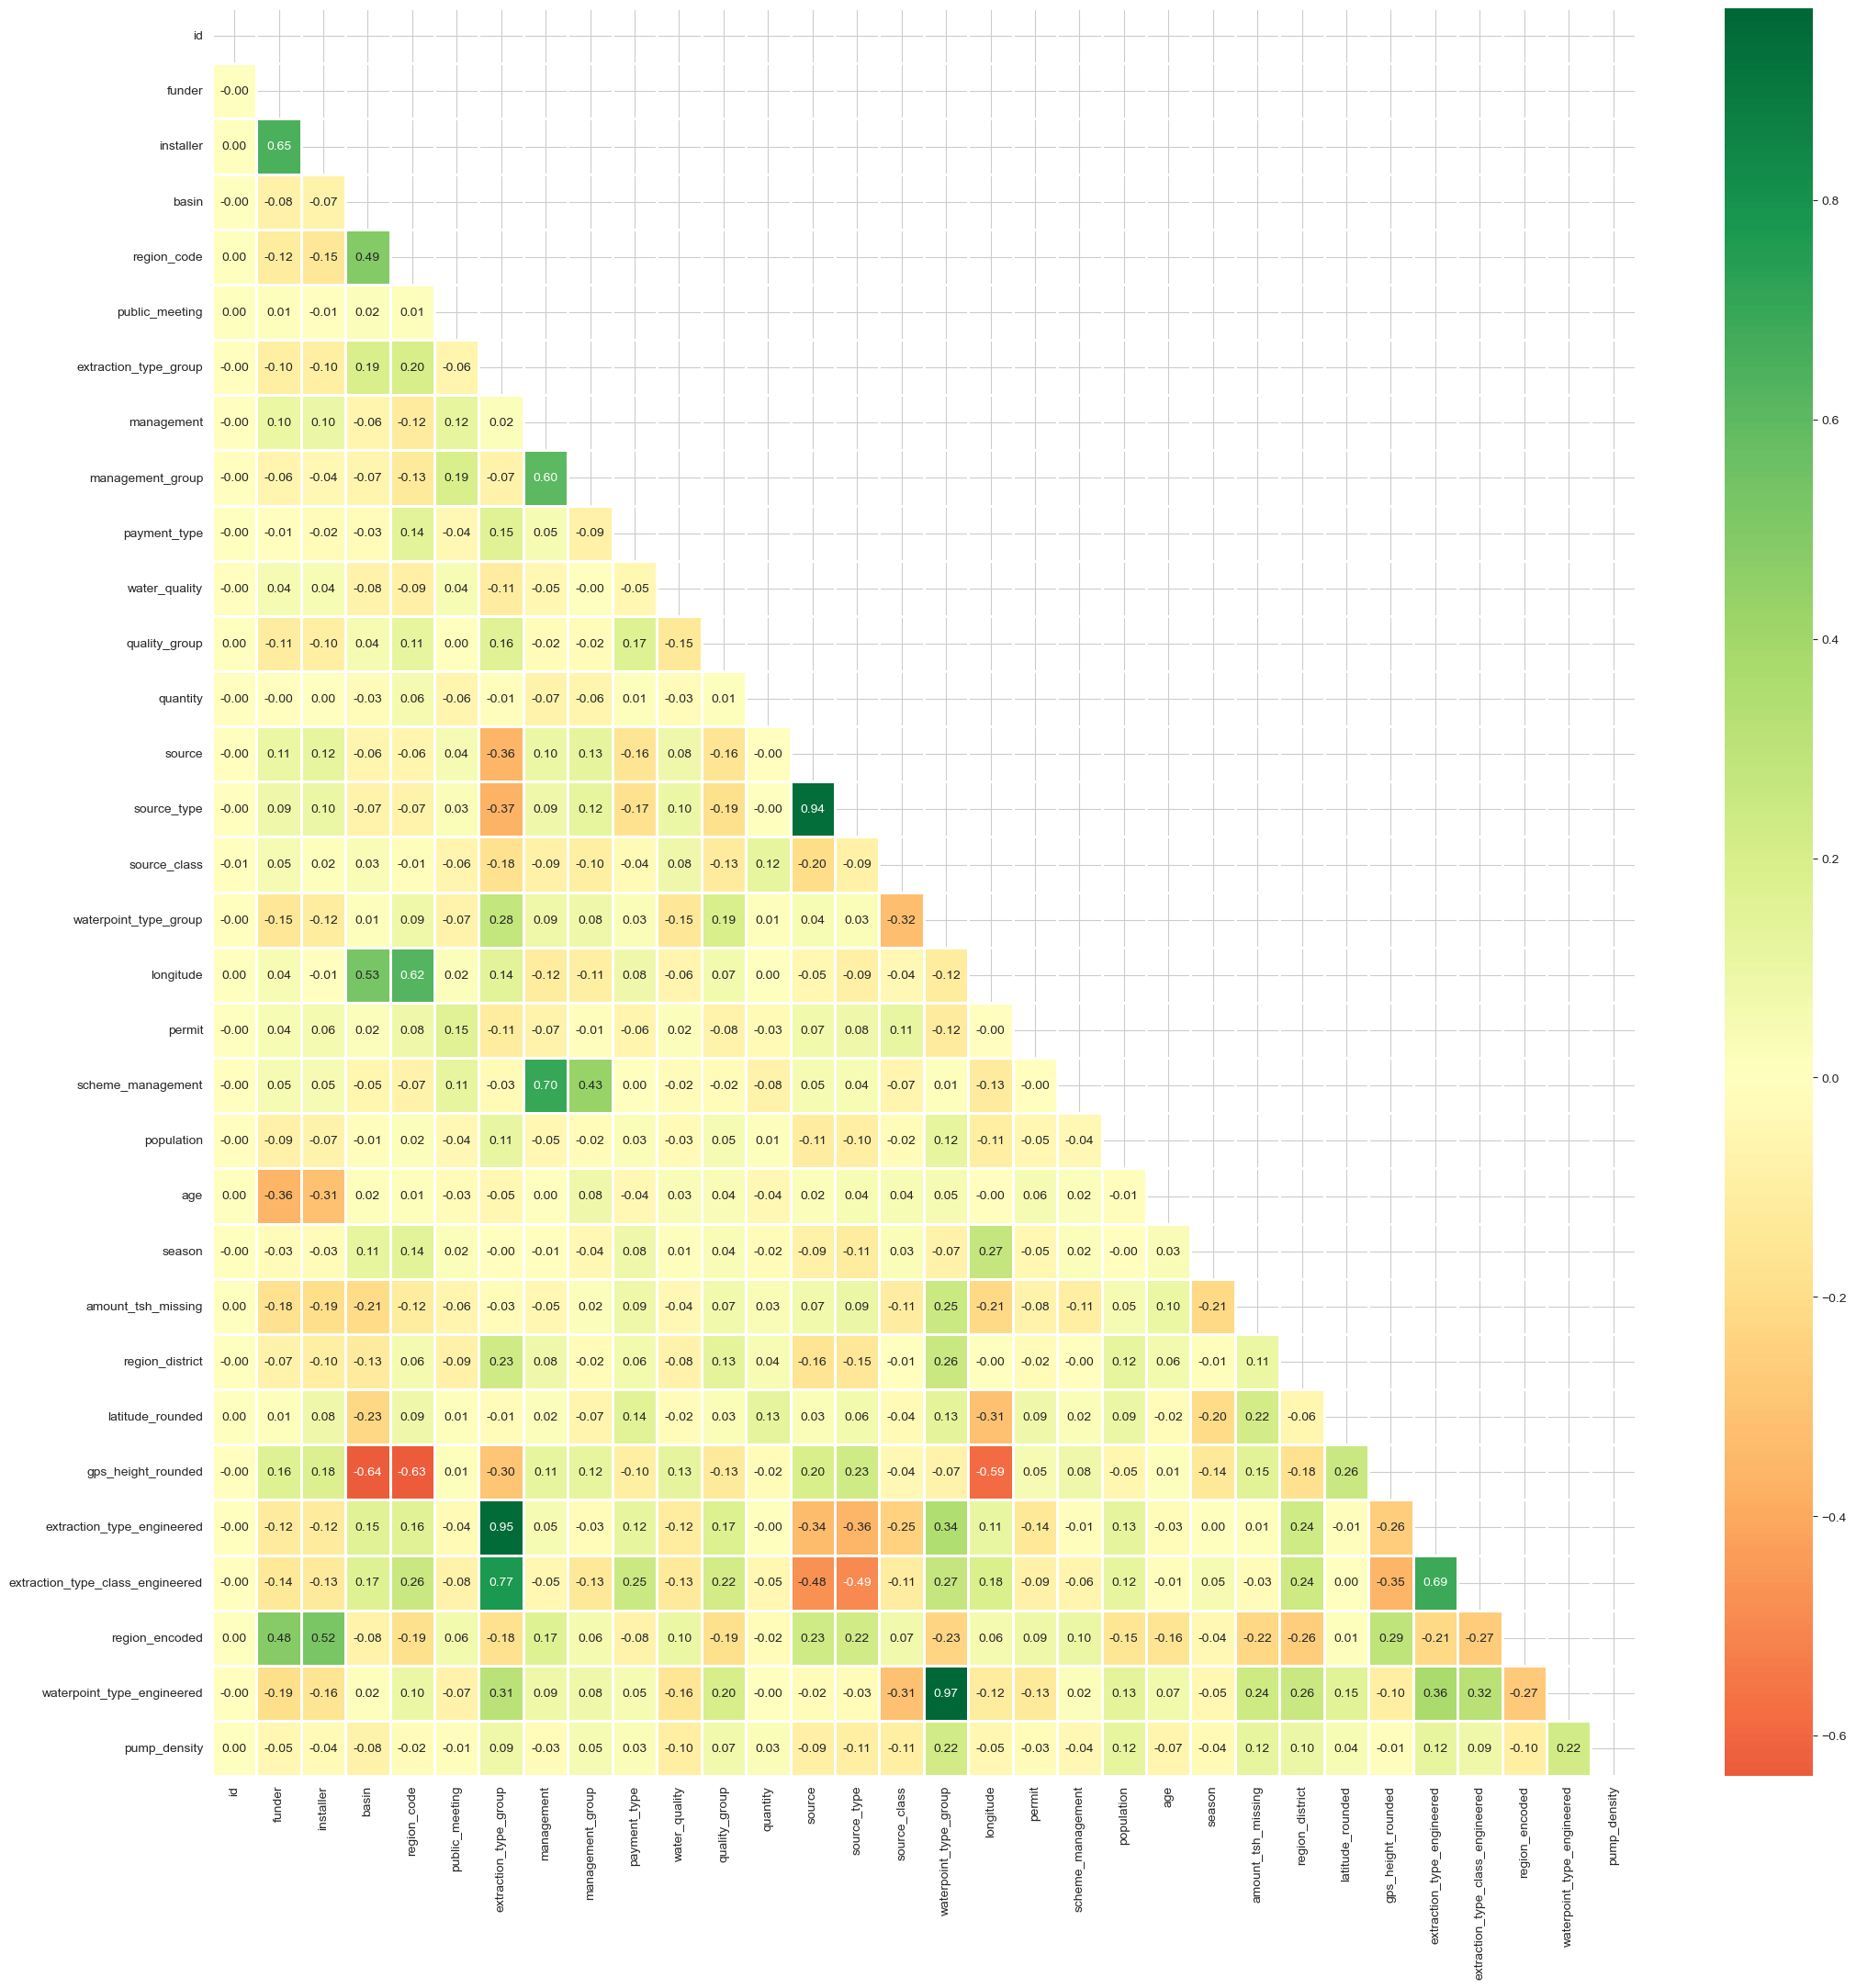

In [ ]:
# Create the correlation matrix
corr_mean = train_set.corr(method = 'pearson')

#create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mean, dtype=bool))

# Add the mask to the heatmap
fig, ax = plt.subplots(figsize=(25,25)) 
ax = sns.heatmap(corr_mean, mask=mask, cmap= "RdYlGn", center=0, linewidths=1, annot=True, fmt=".2f")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_xticklabels())
plt.show()

Multicolllinearity

In [ ]:
le = LabelEncoder()
train_set['status_group'] = le.fit_transform(train_set['status_group'])

/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_23830/3127022900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['status_group'] = le.fit_transform(train_set['status_group'])


In [ ]:
vif_df =calc_vif(train_set)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head(10)

,variables,VIF
18,longitude,189.521358
14,source,112.885147
17,waterpoint_type_group,76.978701
15,source_type,48.288737
31,waterpoint_type_engineered,43.351903
7,extraction_type_group,41.708103
11,water_quality,41.392730
8,management,39.601661
28,extraction_type_engineered,33.064219
20,scheme_management,31.189535


Feature Importance

In [ ]:
# #define X and y varaibles
# X = train_set.drop(['status_group', 'id'],axis=1)
# y = train_set['status_group']

# #instantiate model and cross_validation
# rf = RandomForestClassifier(random_state =42)
# cv = KFold(n_splits=10, shuffle = True,  random_state=1)

# #perform cross-validaton
# n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# #plot feature importance
# feature_importances (rf, " full feature set")

VIF

In [ ]:
# FIND OUT WHICH FEATURES HAVE HIGH VIF FIRST

# #define X and y varaibles
# X = train_set[['amount_tsh', 'date_recorded', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'lga', 'ward', 'recorded_by', 'scheme_name', 'extraction_type_class',
#               'payment', 'quantity', 'source_class', 'waterpoint_type_group', 'permit', 'population']]
# y = train_set['status_group']

# #instantiate model and cross_validation
# rf = RandomForestClassifier(random_state =42)
# cv = KFold(n_splits=10, shuffle = True,  random_state=1)

# #perform cross-validaton
# n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# #plot feature importance
# feature_importances (rf, " VIF feature set")

RFECV

In [ ]:
train_set.columns

Index(['id', 'status_group', 'funder', 'installer', 'basin', 'region_code',
       'public_meeting', 'extraction_type_group', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type_group', 'longitude', 'permit', 'scheme_management',
       'population', 'age', 'season', 'amount_tsh_missing', 'region_district',
       'latitude_rounded', 'gps_height_rounded', 'extraction_type_engineered',
       'extraction_type_class_engineered', 'region_encoded',
       'waterpoint_type_engineered', 'pump_density'],
      dtype='object')

In [ ]:
if sw_rfecv:

    #define X and y varaibles
    X = train_set.drop(['status_group', 'id'], axis=1)
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42)

    rf = RandomForestClassifier(random_state =42)
    rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy', verbose = 1,  min_features_to_select=20) 

    #transform
    rfecv.fit(X_train, y_train)
    rfecv.transform(X_train)

    #predict
    y_pred = rfecv.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %.3f' % (accuracy))

Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 fe

In [ ]:
train_df.columns

Index(['id', 'status_group', 'funder', 'installer', 'basin', 'region_code',
       'public_meeting', 'extraction_type_group', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type_group', 'longitude', 'permit', 'scheme_management',
       'population', 'age', 'season', 'amount_tsh_missing', 'region_district',
       'latitude_rounded', 'gps_height_rounded', 'extraction_type_engineered',
       'extraction_type_class_engineered', 'region_encoded',
       'waterpoint_type_engineered', 'pump_density'],
      dtype='object')

In [ ]:
if sw_rfecv:

    #let's check what features were dropped at each iteration
    support = rfecv.support_.tolist()
    ranking = rfecv.ranking_.tolist()
    columns = X_train.columns.tolist()

    d = {'Feature':columns,'Support': support, 'Ranking': ranking}  
    score_df = pd.DataFrame(d)
    score_df  = score_df .sort_values( 'Ranking', ascending = True)
    print(score_df)

    cols_todrop = score_df[score_df['Support'] == False]['Feature'].tolist()
    train_df = train_df.drop(cols_todrop, axis=1)

    print(cols_todrop)

                             Feature  Support  Ranking
0                             funder     True        1
28                    region_encoded     True        1
27  extraction_type_class_engineered     True        1
26        extraction_type_engineered     True        1
25                gps_height_rounded     True        1
24                  latitude_rounded     True        1
23                   region_district     True        1
22                amount_tsh_missing     True        1
20                               age     True        1
19                        population     True        1
16                         longitude     True        1
29        waterpoint_type_engineered     True        1
15             waterpoint_type_group     True        1
30                      pump_density     True        1
1                          installer     True        1
11                          quantity     True        1
10                     quality_group     True        1
3         

In [ ]:
train_df.columns

Index(['id', 'status_group', 'funder', 'installer', 'region_code',
       'extraction_type_group', 'management', 'payment_type', 'quality_group',
       'quantity', 'source', 'waterpoint_type_group', 'longitude',
       'population', 'age', 'amount_tsh_missing', 'region_district',
       'latitude_rounded', 'gps_height_rounded', 'extraction_type_engineered',
       'extraction_type_class_engineered', 'region_encoded',
       'waterpoint_type_engineered', 'pump_density'],
      dtype='object')

# Feature Normalisation

by Adam

### Min-Max Scaling

In [ ]:
if sw_minmax_scale:
    features = train_df.drop(["status_group", "id"], axis=1)
    # Create an instance of MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler to your data
    scaler.fit(features)

    # Perform min-max scaling on your data
    train_df[features.columns] = scaler.transform(features)

### Z-score Normalisation

In [ ]:
if(sw_zscore_scale):
    features = train_df.drop(["status_group", "id"], axis=1)

    scaler = StandardScaler()
    scaler.fit(features)
    train_df[features.columns] = scaler.transform(features)


### Custom Scaling
Manually combine Min-Max scaling, Z-score normalisation and Robust scaling on a feature-by-feature basis.

In [ ]:
if(sw_custom_scale):
    features = train_df.drop(["status_group", "id"], axis=1)
    
    print(features.columns)
    # Z Score
    zscoreColumns = ["age", "pump_density"]

    # MinMax
    minmaxColumns = ["latitude", "longitude", "gps_height"]

    # Normalisation for when there's outliers
    robustColumns = ["population"]

    mmScaler = MinMaxScaler()
    zScaler = StandardScaler()
    rScaler = RobustScaler()

    zscoreColumns = [col for col in zscoreColumns if col in train_df.columns]
    minmaxColumns = [col for col in minmaxColumns if col in train_df.columns]
    robustColumns = [col for col in robustColumns if col in train_df.columns]

    # Fit the scalers to data
    if len(minmaxColumns) > 0: mmScaler.fit(train_df[minmaxColumns])
    if len(zscoreColumns) > 0:zScaler.fit(train_df[zscoreColumns])
    if len(robustColumns) > 0:rScaler.fit(train_df[robustColumns])

    # Apply scaling to each column group
    if len(zscoreColumns) > 0: train_df[zscoreColumns] = zScaler.transform(train_df[zscoreColumns])
    if len(minmaxColumns) > 0: train_df[minmaxColumns] = mmScaler.transform(train_df[minmaxColumns])
    if len(robustColumns) > 0: train_df[robustColumns] = rScaler.transform(train_df[robustColumns])

Index(['funder', 'installer', 'region_code', 'extraction_type_group',
       'management', 'payment_type', 'quality_group', 'quantity', 'source',
       'waterpoint_type_group', 'longitude', 'population', 'age',
       'amount_tsh_missing', 'region_district', 'latitude_rounded',
       'gps_height_rounded', 'extraction_type_engineered',
       'extraction_type_class_engineered', 'region_encoded',
       'waterpoint_type_engineered', 'pump_density'],
      dtype='object')


# Dimensionality Reduction

by Adam

### PCA

In [ ]:
if sw_pca:
    # Number of components to use
    pca_num_components = 8

    features = train_df[train_df["status_group"].notnull()]
    labels = features["status_group"]
    features = features.drop(["status_group", "id"], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(features, labels)

    bestScore = 0
    bestIdx = 0
    for i in range(4, len(features.columns)):
        
        # Apply PCA to all columns
        pca = PCA(n_components=i)
        pcaModel = pca.fit(X_train)
        pca_train = pcaModel.transform(X_train)
        pca_test = pcaModel.transform(X_test)
        pca_train = pd.DataFrame(pca_train)
        pca_test = pd.DataFrame(pca_test)

        # Test PCA output on random forests classifier
        rf = RandomForestClassifier(random_state=42)

        rf = rf.fit(pca_train, y_train)
        preds = rf.predict(pca_test)


        accuracy = accuracy_score(preds, y_test)
        print(i)
        print('Accuracy: %.3f' % (accuracy))
        if accuracy > bestScore:
            bestScore = accuracy
            bestIdx = i
    
    pca = PCA(n_components=bestIdx)
    pca_data = pd.DataFrame(pca.fit_transform(train_df.drop(["status_group", "id"], axis=1)))
    train_df = pd.concat([pca_data, train_df[["status_group", "id"]]])

### LDA

In [ ]:
if(sw_lda):

    features = train_df.drop(["status_group", "id"], axis=1)
    train_features = features[train_df["status_group"].notna()]

    test_features = features[train_df["status_group"].isna()]

    train_labels = train_df["status_group"].dropna()
    lda = LinearDiscriminantAnalysis()

    # Fit the LDA model to the scaled features and target variable
    lda = lda.fit(train_features, train_labels)

    # Transform the features to the LDA space
    train_out = lda.transform(train_features)
    test_out = lda.transform(test_features)

    train_lda = pd.DataFrame(train_out, columns=['out_1', 'out_2'])
    test_lda = pd.DataFrame(train_out, columns=['out_1', 'out_2'])

    lda_df = pd.concat([train_lda, test_lda], axis=0)

    train_df = pd.concat([lda_df, train_df[["id", "status_group"]]], axis=1)

### Truncated SVD

In [ ]:
if(sw_tsvd):
    from sklearn import decomposition
    tsvd_num_components = 8

    features = train_df.drop(["status_group", "id"], axis=1).astype(float)
    print(features.dtypes)

    svd = decomposition.TruncatedSVD(n_components=tsvd_num_components, algorithm='arpack')
    features = svd.fit_transform(features)

    component_columns = [f'component{i+1}' for i in range(features.shape[1])]
    features = pd.DataFrame(data=features, columns=component_columns)

    #test_features = svd.transform(test_features)
    train_df = pd.concat([features, train_df[["id", "status_group"]]], axis=1)